### Import library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from basic_image_eda import BasicImageEDA # https://github.com/Soongja/basic-image-eda
from skimage.color import rgb2lab, lab2rgb

import glob
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from itertools import islice


##  EDA

Dataset directories

In [10]:
space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

tree(r'D:\data\imagenet-object-localization-challenge\ILSVRC', level=3, limit_to_directories=True)


ILSVRC
├── Annotations
│   └── CLS-LOC
│       ├── train
│       └── val
├── Data
│   └── CLS-LOC
│       ├── test
│       ├── train
│       └── val
└── ImageSets
    └── CLS-LOC

11 directories


### Image path

We use glob to retrieve all pathnames of the images

In [5]:
train_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\train"
val_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\val"
test_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\test"
train_img_paths = glob.glob(train_path + "/**/*.jpeg", recursive=True)
val_img_paths = glob.glob(val_path + "/**/*.JPEG", recursive=True)
test_img_paths = glob.glob(test_path + "/**/*.JPEG", recursive=True)


The number of images of each set

In [6]:
print("train images: ", len(train_img_paths))
print("val images: ", len(val_img_paths))
print("test images: ", len(test_img_paths))

train images:  1281167
val images:  50000
test images:  100000


In [2]:
def get_dims(file):
    """Opening the image file and converting it to an array. Then it is getting the height, width, and depth of the image.

    Args:
        file (_type_): _description_
    Returns:
        _type_: _description_
    """
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

Explore the dataset with BasicImageEDA package


found 1281167 images.
Using 12 threads. (max:12)



100%|██████████| 1281167/1281167 [6:42:44<00:00, 53.02it/s]    



*--------------------------------------------------------------------------------------*
number of images                         |  1281167

dtype                                    |  uint8
channels                                 |  [1, 3, 4]
extensions                               |  ['JPEG']

min height                               |  10
max height                               |  6530
mean height                              |  405.5081991652923
median height                            |  375

min width                                |  8
max width                                |  9331
mean width                               |  472.9900777962592
median width                             |  500

mean height/width ratio                  |  0.8573291876536261
median height/width ratio                |  0.75
recommended input size(by mean)          |  [408 472] (h x w, multiples of 8)
recommended input size(by mean)          |  [400 480] (h x w, multiples of 16)
recommended input

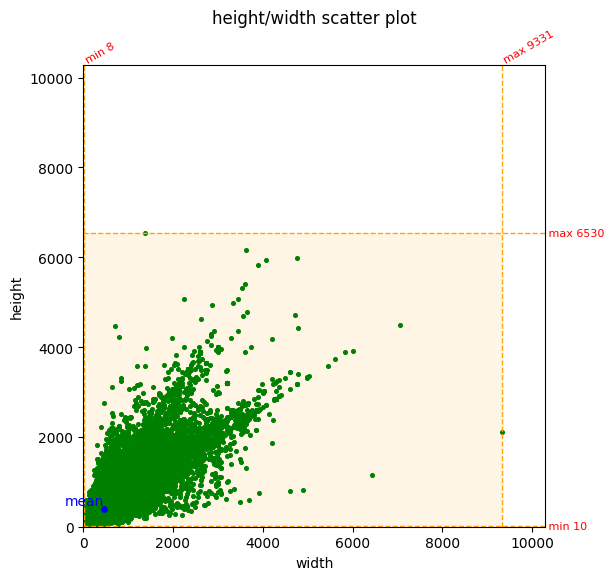

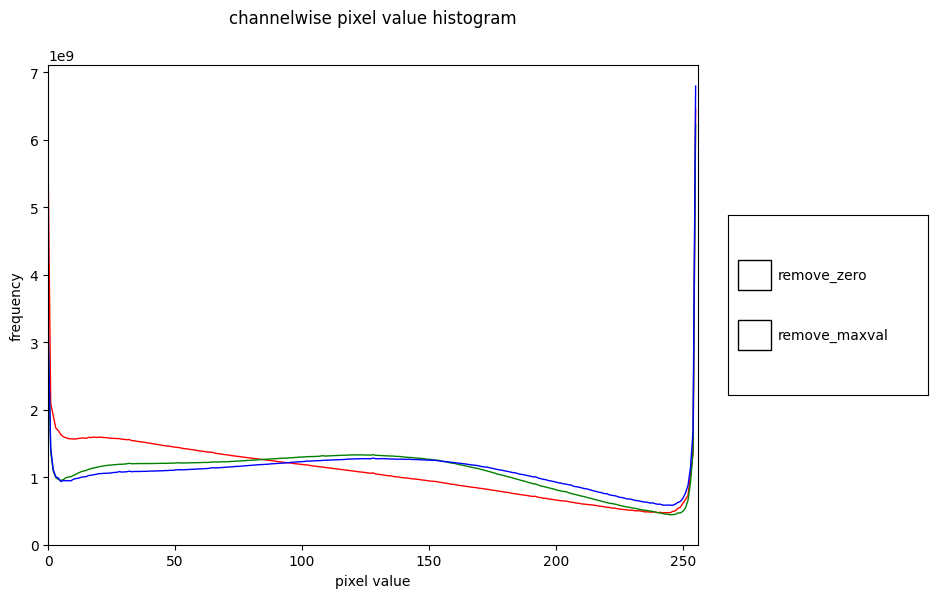

{'dtype': 'uint8',
 'channels': [1, 3, 4],
 'extensions': ['JPEG'],
 'min_h': 10,
 'max_h': 6530,
 'mean_h': 405.5081991652923,
 'median_h': 375,
 'min_w': 8,
 'max_w': 9331,
 'mean_w': 472.9900777962592,
 'median_w': 500,
 'mean_hw_ratio': 0.8573291876536261,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([408, 472]),
 'rec_hw_size_16': array([400, 480]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.40778415, 0.45743027, 0.48104194]),
 'std': array([0.289686  , 0.27622591, 0.2833912 ])}

In [5]:
extensions = ['jpeg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0
BasicImageEDA.explore(train_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)


found 50000 images.
Using 12 threads. (max:12)



100%|██████████| 50000/50000 [12:27<00:00, 66.85it/s] 



*--------------------------------------------------------------------------------------*
number of images                         |  50000

dtype                                    |  uint8
channels                                 |  [1, 3]
extensions                               |  ['JPEG']

min height                               |  56
max height                               |  5005
mean height                              |  430.25888
median height                            |  375

min width                                |  54
max width                                |  4288
mean width                               |  490.38648
median width                             |  500

mean height/width ratio                  |  0.8773873211186409
median height/width ratio                |  0.75
recommended input size(by mean)          |  [432 488] (h x w, multiples of 8)
recommended input size(by mean)          |  [432 496] (h x w, multiples of 16)
recommended input size(by mean)      

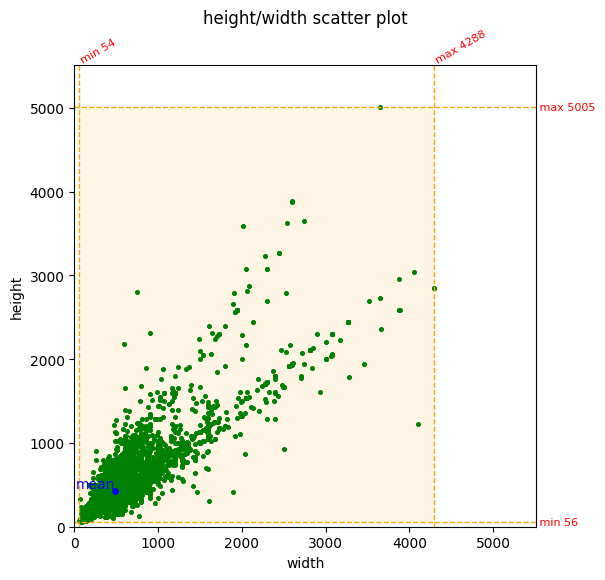

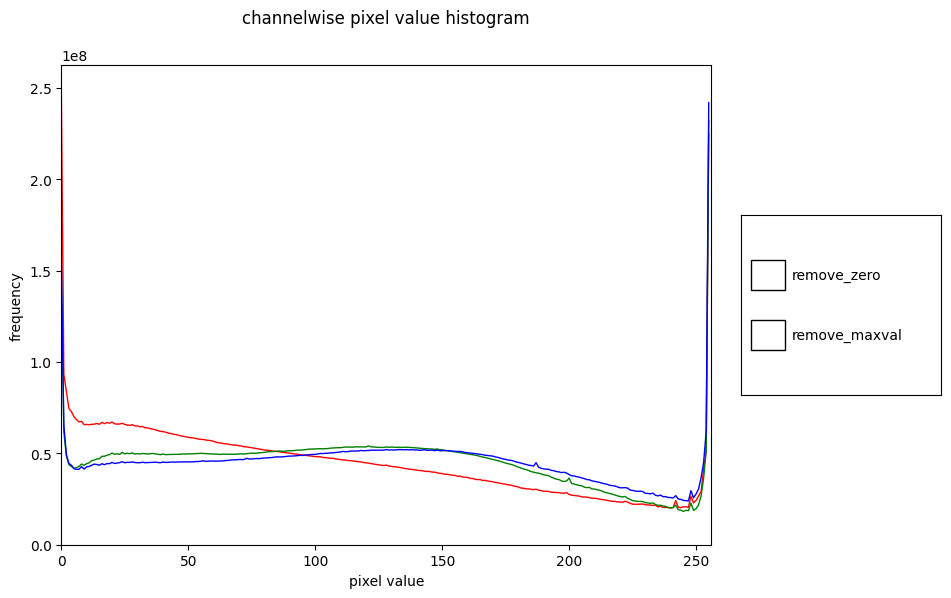

{'dtype': 'uint8',
 'channels': [1, 3],
 'extensions': ['JPEG'],
 'min_h': 56,
 'max_h': 5005,
 'mean_h': 430.25888,
 'median_h': 375,
 'min_w': 54,
 'max_w': 4288,
 'mean_w': 490.38648,
 'median_w': 500,
 'mean_hw_ratio': 0.8773873211186409,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([432, 488]),
 'rec_hw_size_16': array([432, 496]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.40106878, 0.45012876, 0.47294503], dtype=float32),
 'std': array([0.28790507, 0.27522925, 0.2819855 ], dtype=float32)}

In [8]:
BasicImageEDA.explore(val_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)


found 100000 images.
Using 12 threads. (max:12)



100%|██████████| 100000/100000 [32:56<00:00, 50.59it/s] 



*--------------------------------------------------------------------------------------*
number of images                         |  100000

dtype                                    |  uint8
channels                                 |  [1, 3]
extensions                               |  ['JPEG']

min height                               |  46
max height                               |  5616
mean height                              |  430.03926
median height                            |  375

min width                                |  44
max width                                |  4752
mean width                               |  490.67573
median width                             |  500

mean height/width ratio                  |  0.8764225204291234
median height/width ratio                |  0.75
recommended input size(by mean)          |  [432 488] (h x w, multiples of 8)
recommended input size(by mean)          |  [432 496] (h x w, multiples of 16)
recommended input size(by mean)     

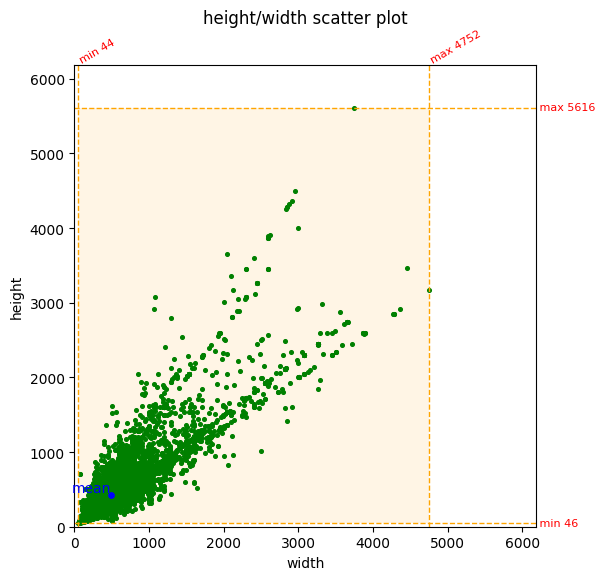

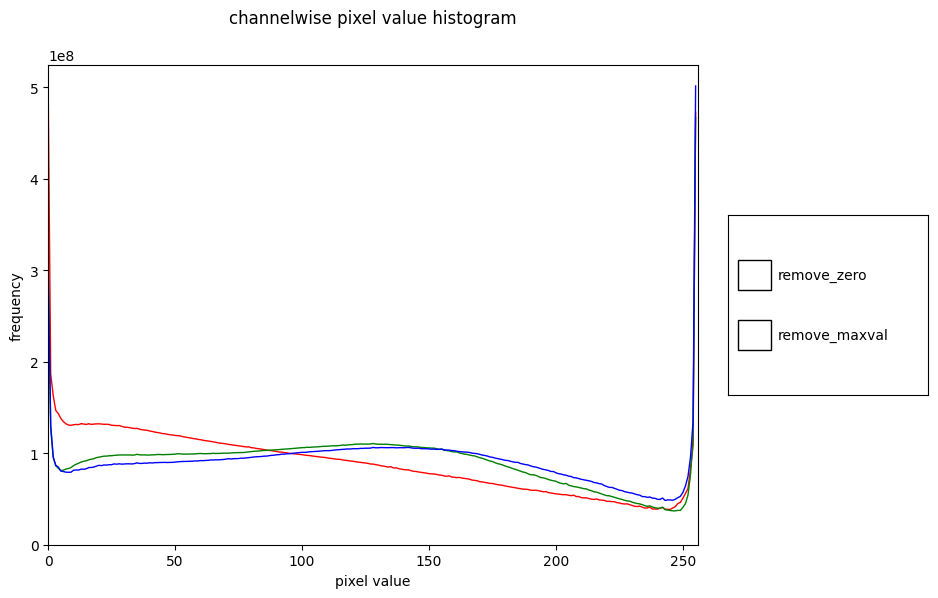

{'dtype': 'uint8',
 'channels': [1, 3],
 'extensions': ['JPEG'],
 'min_h': 46,
 'max_h': 5616,
 'mean_h': 430.03926,
 'median_h': 375,
 'min_w': 44,
 'max_w': 4752,
 'mean_w': 490.67573,
 'median_w': 500,
 'mean_hw_ratio': 0.8764225204291234,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([432, 488]),
 'rec_hw_size_16': array([432, 496]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.4009243 , 0.45119215, 0.47435094]),
 'std': array([0.28807724, 0.27551642, 0.2822851 ])}

In [9]:
BasicImageEDA.explore(test_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

## Create a dataset class
Perform data processing with resizing and converting RGB to LAB color space

In [20]:
SIZE = 256
class ColorizationDataset:
    def __init__(self, paths, split = 'train') -> None:
        # set self.transforms based on split type 
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE,SIZE), Image.BICUBIC), # Resize the image to 256x256, using bicubic interpolation (default)
                transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
                transforms.RandomVerticalFlip(), # Randomly flip the image vertically
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), Image.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx].convert("RGB"))
        img = self.transforms(img)  
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # convert to lab color space and convert to float32
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] # luminance channel (black and white) - [0~100] - this is what we will give to the network as input 
        ab = img_lab[[1, 2], ...] # color channels - [-128~127] - these are what we will predict with the network
        
        L = L / 50 - 1 # normalize L channel to [-1,1]
        ab = 2 * (ab + 128) / 255 - 1 # normalize ab channels to [-1,1]
        return {"L": L, "ab": ab}
    
    def __len__(self):
        "Returning the length of the dataset."
        return len(self.paths) 
    
def make_loader(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    ds = ColorizationDataset(**kwargs)
    loader = DataLoader(ds, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)
    return loader
        

In [7]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super.__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, inplace=True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.relu(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost: 
            upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        if innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        return torch.cat([x, self.model(x)], 1)
    
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters)
            
        

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
col = 4
row = 5
ax = []
for i in range(col * row):
    img = np.array(Image)
    ax.append(fig.add_subplot(row, col, i+1))
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img)
    

In [34]:
img = Image.open(train_img_paths[12])
type(img)

AttributeError: 'list' object has no attribute 'read'

In [32]:
from tensorflow.keras.utils import img_to_array
arr = img_to_array(img)
print(arr.shape)

(511, 640, 3)


In [33]:
b = np.array(arr)
b

array([[[ 74.,  37.,  19.],
        [ 96.,  59.,  40.],
        [122.,  86.,  62.],
        ...,
        [ 13.,  15.,   2.],
        [  2.,   4.,   0.],
        [ 26.,  28.,  17.]],

       [[ 62.,  39.,   8.],
        [ 99.,  74.,  44.],
        [124.,  99.,  69.],
        ...,
        [ 24.,  26.,  13.],
        [ 24.,  26.,  13.],
        [ 21.,  23.,  10.]],

       [[ 71.,  57.,  20.],
        [ 91.,  77.,  42.],
        [ 96.,  82.,  47.],
        ...,
        [ 16.,  18.,   4.],
        [ 19.,  21.,   7.],
        [  8.,  10.,   0.]],

       ...,

       [[  7.,  12.,   6.],
        [  5.,  14.,   0.],
        [ 11.,  25.,   0.],
        ...,
        [ 61.,  57.,  45.],
        [ 83.,  77.,  63.],
        [ 78.,  70.,  57.]],

       [[ 13.,  16.,   9.],
        [  6.,  12.,   0.],
        [  4.,  16.,   0.],
        ...,
        [ 17.,  16.,  11.],
        [ 24.,  20.,  17.],
        [ 19.,  15.,  12.]],

       [[  5.,   6.,   0.],
        [  8.,  12.,   0.],
        [  8.,  

In [ ]:
from copy import copy

count = 1
fig = plt.figure(figsize=(12, 3*b))
    